In [6]:
import pandas as pd

# Example: load 2023 season play-by-play

def show_columns(filename): 
    df = pd.read_csv(filename)
    
    # https://github.com/nflverse/nflverse-data/releases/tag/pbp
    
    print(df.columns)
    df.head()
    
    for column_name in df:
        print(f"{column_name}")


In [25]:
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values

def load_data(filename): 
    
    DB_CONFIG = {
        "dbname": "nfl_historical",
        "user": "postgres",
        "password": "postgres",
        "host": "localhost",
        "port": 5432,
    }
    
    # === READ CSV ===
    df = pd.read_csv(filename)
    
    # === CONNECT TO DATABASE ===
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    
    
    # === CREATE TABLES IF NOT EXIST ===
    cur.execute("""
    CREATE TABLE IF NOT EXISTS games (
        id TEXT PRIMARY KEY,
        home_team TEXT NOT NULL,
        away_team TEXT NOT NULL,
        description TEXT NOT NULL,
        game_date date NOT NULL,
        season_type TEXT NOT NULL,
        week smallint NOT NULL
    );
    """)
    
    cur.execute("""
    CREATE TABLE IF NOT EXISTS plays (
        id TEXT PRIMARY KEY,
        game_id TEXT NOT NULL REFERENCES games(id) ON DELETE CASCADE,
        posteam TEXT NOT NULL,
        posteam_type TEXT NOT NULL,
        defteam TEXT NOT NULL,
        total_home_score int,
        total_away_score int,
        qtr smallint,
        quarter_seconds_remaining float,
        game_seconds_remaining float
    );
    """)
    
    conn.commit()
    
    # === INSERT INTO games ===
    # Use UPSERT to avoid duplicates (in case same game appears multiple times)
    games = df[["game_id", "home_team", "away_team", "desc", "game_date", "season_type", "week", ]].drop_duplicates(subset=["game_id"])
    
    execute_values(
        cur,
        """
        INSERT INTO games (id, home_team, away_team, description, game_date, season_type, week)
        VALUES %s
        ON CONFLICT (id) DO UPDATE SET 
          home_team = EXCLUDED.home_team,
          away_team = EXCLUDED.away_team,
          game_date = EXCLUDED.game_date,
          season_type = EXCLUDED.season_type,
          week = EXCLUDED.week
        """,
        list(games.itertuples(index=False, name=None))
    )
    
    # === INSERT INTO plays ===
    plays = df[["play_id", "game_id", "posteam", "posteam_type", "defteam", "total_home_score", "total_away_score", "qtr", "quarter_seconds_remaining", "game_seconds_remaining"]].drop_duplicates(subset=["play_id"])
    
    plays["play_id"] = plays["game_id"].astype(str) + "_" + plays["play_id"].astype(str)
    
    execute_values(
        cur,
        """
        INSERT INTO plays (
            id, 
            game_id, 
            posteam, 
            posteam_type, 
            defteam,
            total_home_score, 
            total_away_score, 
            qtr,
            quarter_seconds_remaining,
            game_seconds_remaining
        )
        VALUES %s
        ON CONFLICT (id) DO UPDATE SET
          game_id = EXCLUDED.game_id,
          posteam = EXCLUDED.posteam,
          posteam_type = EXCLUDED.posteam_type,
          defteam = EXCLUDED.defteam,
          total_home_score = EXCLUDED.total_home_score,
          total_away_score = EXCLUDED.total_away_score,
          qtr = EXCLUDED.qtr,
          quarter_seconds_remaining = EXCLUDED.game_seconds_remaining,
          game_seconds_remaining = EXCLUDED.game_seconds_remaining
        """,
        list(plays.itertuples(index=False, name=None))
    )
    
    # === COMMIT AND CLEANUP ===
    conn.commit()
    cur.close()
    conn.close()
    
    print("Data import completed successfully.")
    print(filename)


In [26]:

#show_columns("./play_by_play_2006.csv");

In [ ]:
#load_data("./play_by_play_2006.csv")
#load_data("./play_by_play_2020.csv")
#load_data("./play_by_play_2021.csv")
load_data("../../data/nfl/play_by_play_2012.csv")
load_data("../../data/nfl/play_by_play_2013.csv")
load_data("../../data/nfl/play_by_play_2014.csv")
load_data("../../data/nfl/play_by_play_2015.csv")
load_data("../../data/nfl/play_by_play_2016.csv")
load_data("../../data/nfl/play_by_play_2017.csv")
load_data("../../data/nfl/play_by_play_2018.csv")
load_data("../../data/nfl/play_by_play_2019.csv")
load_data("../../data/nfl/play_by_play_2022.csv")
#load_data("./play_by_play_2023.csv")
#load_data("./play_by_play_2024.csv")

/tmp/ipykernel_47431/560418442.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  games = pd.read_sql("SELECT * FROM games WHERE final_home_score is not null;", conn)
/tmp/ipykernel_47431/560418442.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  plays = pd.read_sql("SELECT * FROM plays;", conn)
/tmp/ipykernel_47431/560418442.py:89: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = result.pivot("time_bucket", "score_bucket", "prob_home_win")


Games: (2050, 9)
Plays: (22600, 10)
                id home_team away_team description   game_date season_type  \
0  2023_01_ARI_WAS       WAS       ARI        GAME  2023-09-10         REG   
1  2023_01_BUF_NYJ       NYJ       BUF        GAME  2023-09-11         REG   
2  2023_01_CAR_ATL       ATL       CAR        GAME  2023-09-10         REG   
3  2023_01_CIN_CLE       CLE       CIN        GAME  2023-09-10         REG   
4  2023_01_DAL_NYG       NYG       DAL        GAME  2023-09-10         REG   

   week  final_home_score  final_away_score  
0     1                20                16  
1     1                16                16  
2     1                24                10  
3     1                24                 3  
4     1                 0                40  
                    id         game_id posteam posteam_type defteam  \
0  2012_01_ATL_KC_2619  2012_01_ATL_KC     ATL         away      KC   
1  2012_01_ATL_KC_2643  2012_01_ATL_KC     ATL         away      KC   
2  201

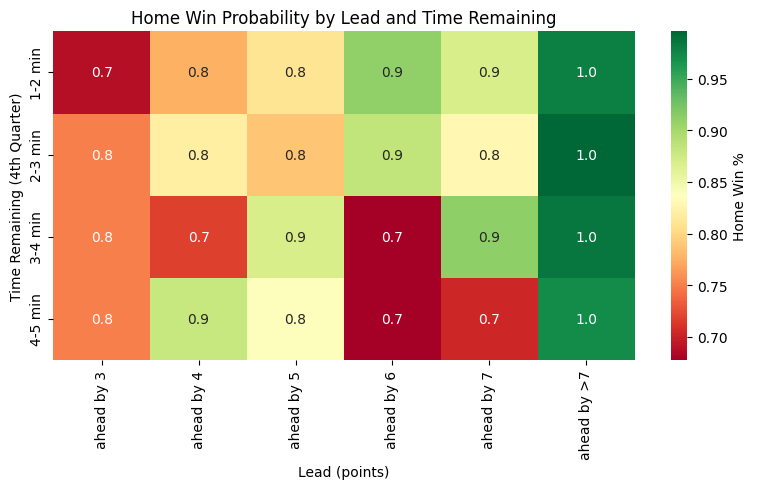

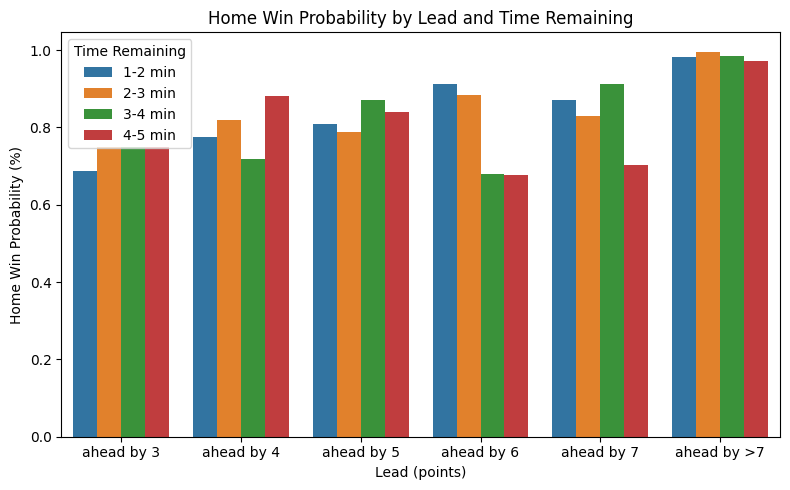

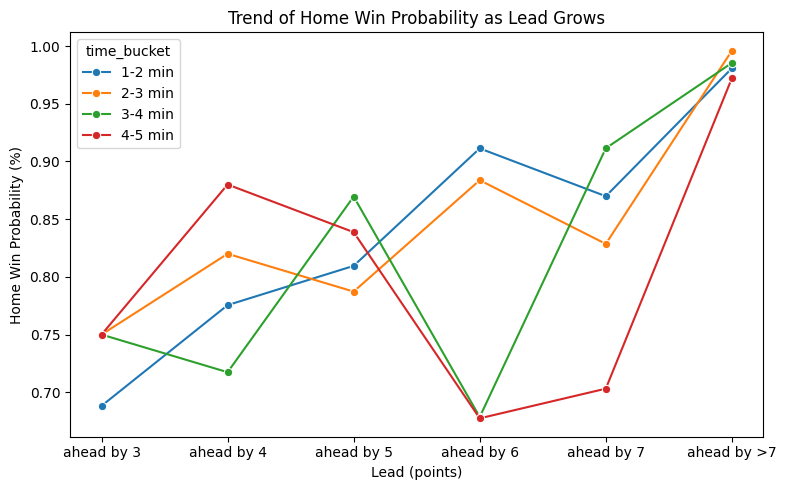

In [51]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_probabilities(): 
    conn = psycopg2.connect(
        host="localhost",        # or your host name
        port="5432",             # default Postgres port
        dbname="nfl_historical",  # change this
        user="postgres",        # change this
        password="postgres" # change this
    )
    
    games = pd.read_sql("SELECT * FROM games WHERE final_home_score is not null;", conn)
    plays = pd.read_sql("SELECT * FROM plays;", conn)
    
    print("Games:", games.shape)
    print("Plays:", plays.shape)
    print(games.head())
    print(plays.head())
    
    conn.close()

    #Add outcome (did home team win?) to each game ---
    games["home_win"] = (games["final_home_score"] > games["final_away_score"]).astype(int)
    
    #Merge plays with their game's win outcome ---
    df = plays.merge(games[["id", "home_win"]], left_on="game_id", right_on="id", how="inner")
    
    #Filter for 4th quarter only ---
    df = df[df["qtr"] == 4].copy()
    
    #Compute score differential (home - away) ---
    df["diff"] = df["total_home_score"] - df["total_away_score"]
    
    #Define time buckets (seconds remaining) ---
    def time_bucket(sec_left):
        if 60 <= sec_left < 120:
            return "1-2 min"
        elif 120 <= sec_left < 180:
            return "2-3 min"
        elif 180 <= sec_left < 240:
            return "3-4 min"
        elif 240 <= sec_left < 300:
            return "4-5 min"
        else:
            return None
    
    df["time_bucket"] = df["game_seconds_remaining"].apply(time_bucket)
    
    #Define score buckets ---
    def score_bucket(diff):
        if diff == 3:
            return "ahead by 3"
        elif diff == 4:
            return "ahead by 4"
        elif diff == 5:
            return "ahead by 5"
        elif diff == 6:
            return "ahead by 6"
        elif diff == 7:
            return "ahead by 7"
        elif diff > 7:
            return "ahead by >7"
        else:
            return None
    
    df["score_bucket"] = df["diff"].apply(score_bucket)
    
    #Filter only cases where home team is leading (diff >= 3) and valid buckets ---
    df = df[(df["diff"] >= 3) & df["time_bucket"].notna() & df["score_bucket"].notna()]
    
    #Aggregate: compute empirical probability ---
    result = (
        df.groupby(["time_bucket", "score_bucket"])
          .agg(
              situations=("game_id", "count"),
              prob_home_win=("home_win", "mean")
          )
          .reset_index()
          .sort_values(["time_bucket", "score_bucket"])
    )
    
    print(result)

    plt.figure(figsize=(8, 5))
    pivot = result.pivot("time_bucket", "score_bucket", "prob_home_win")
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': 'Home Win %'})
    plt.title("Home Win Probability by Lead and Time Remaining")
    plt.xlabel("Lead (points)")
    plt.ylabel("Time Remaining (4th Quarter)")
    plt.tight_layout()
    plt.show()
    
    # --- 2️⃣ BAR CHART ---
    plt.figure(figsize=(8, 5))
    sns.barplot(data=result, x="score_bucket", y="prob_home_win", hue="time_bucket")
    plt.title("Home Win Probability by Lead and Time Remaining")
    plt.xlabel("Lead (points)")
    plt.ylabel("Home Win Probability (%)")
    plt.legend(title="Time Remaining")
    plt.tight_layout()
    plt.show()
    
    # --- 3️⃣ (Optional) LINE PLOT for trend visualization ---
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=result, x="score_bucket", y="prob_home_win", hue="time_bucket", marker="o")
    plt.title("Trend of Home Win Probability as Lead Grows")
    plt.xlabel("Lead (points)")
    plt.ylabel("Home Win Probability (%)")
    plt.tight_layout()
    plt.show()
calculate_probabilities()